## Image Classiﬁcation Using Bag-of-words

This project deals with building a classifier to determine whether an input image contains a face. We will be using a bag-of-words representations for images and use a K-nearest neighbor classification to classify images as with a face, or without a face. 

* **Region Selection**: Select some regions in the images so that we can extract features from those regions in the next step. The regions can be selected by feature detection methods like edge or corner detection, or you can just uniformly sample the image. 

* **Feature Extraction**: We extract features from the selected regions. One commonly used feature is SIFT. We extract features from every image in the training set. These features are collected to compute the visual vocabulary for image representation.  

* **Building visual vocabulary**: Once we have the features extracted from training images, we build a visual vocabulary by grouping them together to form a few clusters. We will use the k-means algorithm to group the features. The reason why we need this step is to reduce the redundancy in feature space and have a more concise feature representation of images. 

* **Learning and recognition**: Given the visual vocabulary, each training image is represented by a histogram, where the features in the image populate bins that correspond to the visual word closest to them. Thereafter, we will use k-nearest neighbors to perform classification for a test image, also represented by a histogram using the same vocabulary.

First, we preprocess the data into two groups for training and testing.

In [2]:
import glob
import random
import numpy as np
from matplotlib import pyplot as plt
import cv2

#code for preprocessing given by Prof Manmohan Chandraker

# Parameters
posData = 'images/face/'
negData = 'images/nonface/'
posTrainRatio = 0.5
negTrainRatio = 0.5
imSize = 133, 200 # resize each image to this size
nIntPts = 200 # maximum number of interest points to be extracted from an image
wGrid = 5 # width of the small grids for uniform sampling
patchSize = 11 # an odd number indicate patch size for image patch feature
nCluster = 50 # number of cluster in k-means algorithm

def listImage(dataRoot):
    fileList = glob.glob(str(dataRoot + '*.jpg'))
    imNum = len(fileList)
    fileList = [fileList[i].replace('\\', '/') for i in range(imNum)]
    return fileList

def loadImage(imgName, imSize):
    # load image, resize and make RGB to grayscale
    img = cv2.imread(imgName)
    img = cv2.resize(img, (imSize[1], imSize[0]))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return img

def createSplit(imgList, ratio):
    random.shuffle(imgList)
    trainList = imgList[:round(len(imgList)*ratio)]
    testList = imgList[round(len(imgList)*ratio):]
    return trainList, testList

# Data preprocessing: Create Training / Testing Split
posList = listImage(posData)
negList = listImage(negData)
trainPosList, testPosList = createSplit(posList, posTrainRatio)
trainNegList, testNegList = createSplit(negList, negTrainRatio)
trainList = trainPosList + trainNegList
trainLabel = np.concatenate((np.ones(len(trainPosList)), np.zeros(len(trainNegList))))
testList = testPosList + testNegList
testLabel = np.concatenate((np.ones(len(testPosList)), np.zeros(len(testNegList))))
testPosLabel = np.ones(len(testPosList))
testNegLabel = np.zeros(len(testNegList))

## Extract interest points from image

Next, we choose interest points in the image to extract for feature extraction. We try two methods for this. Firstly, we simply uniformly sample the image. Next, we use the Harris Corner Detector to detect corners in the image.

Interest Points extracted by uniform (above) and edge (below) method:


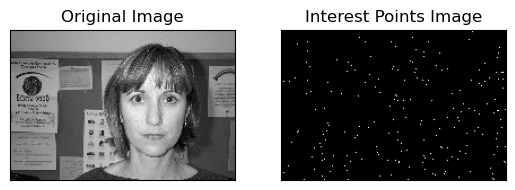

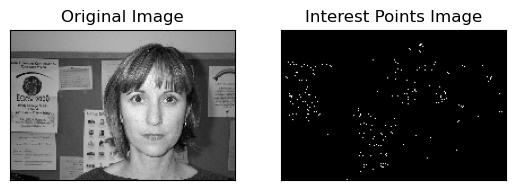

In [3]:
def uniformSampling(imSize, nPts, wGrid):
    # keep a list of potential interest points (ptList)
    # iterate through each grid of wGrid by wGrid, and choose 1 random point to add to ptList
    # add it to ptList
    # if ptList has less pts than nPts, then return ptList, if not, return a randomly selected nPts number of pts in ptList
    
    ptList = []
    for i in range(int(imSize[0]/wGrid)):
        for j in range(int(imSize[1]/wGrid)):
            gridPtList = []
            
            for i1 in range(i*wGrid, (i+wGrid)*wGrid):
                for j1 in range(j*wGrid, (j+wGrid)*wGrid):
                    if i1>=imSize[0] or j1>=imSize[1]:
                        continue
                    gridPtList.append((i1,j1))
            
            pt = random.choice(gridPtList)
            ptList.append(pt)
    
    if len(ptList) <= nPts:
        return ptList
    
    return random.sample(ptList,nPts)

# skeleton code for corner sampling provided by Manhmohan Chandraker
def cornerSampling(img, nPts):
    dst = cv2.cornerHarris(img,2,3,0.04)
    dst = cv2.dilate(dst,None)
    cor = np.zeros(img.shape)
    cor[dst>0.01*dst.max()]=[1]
    ptsY, ptsX = np.where(cor==1)
    num = min(nPts, len(ptsY))
    choice = np.random.choice(len(ptsY), num, replace=False)
    ptsY = ptsY[choice]
    ptsX = ptsX[choice]
    pts = [(ptsY[i], ptsX[i]) for i in range(num)]
    return pts

def plotInterestPoints(img, pts, idx=0):
    ptsMap = np.zeros(img.shape)
    ptsY = [Y for Y, X in pts]
    ptsX = [X for Y, X in pts]
    ptsMap[ptsY, ptsX] = 1
    plt.figure(idx)
    plt.subplot(121),plt.imshow(img,cmap = 'gray')
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(ptsMap,cmap = 'gray')
    plt.title('Interest Points Image'), plt.xticks([]), plt.yticks([])

sampleImg = loadImage(trainList[0], imSize)
print('Interest Points extracted by uniform (above) and edge (below) method:')
ptsU = uniformSampling(imSize, nIntPts, wGrid)
plotInterestPoints(sampleImg, ptsU, idx=0)
ptsE = cornerSampling(sampleImg, nIntPts)
plotInterestPoints(sampleImg, ptsE, idx=1)

## Extracting features 

Now we extract features from the selected regions above. We use these extracted features to compute the visual vocabulary used for face classification. We use two methodologies to do this, one is to use the SIFT implementation in the OpenCV package, and the other is to manually extract a small image patch around each feature point. 

In [4]:
def extractSIFTfeature(img, pts):

    # skeleton code for extracting SIFT features was provided by Manmohan Chandraker

    sift = cv2.SIFT_create()
    kp = [cv2.KeyPoint(float(ptsX), float(ptsY), 1) for ptsY, ptsX in pts]
    _, des = sift.compute(img, kp)
    features = [des[i] for i in range(des.shape[0])]
    return features

def extractImagePatchfeature(img, pts, patchSize):
    # for each point in pts, check whether the bounds of the patch for patchSize are in the image or not
    # if not, ignore. If in, then iterate through the patch and put all pixel values in a 1d array
    # append that 1d array into features
    
    features = []
    for pt in pts:
        # checking bounds
        xMin = int(pt[1] - (patchSize-1)/2)
        xMax = int(pt[1] + (patchSize-1)/2)
        yMin = int(pt[0] - (patchSize-1)/2)
        yMax = int(pt[0] + (patchSize-1)/2)

        if xMin<0 or yMin<0 or xMax>=len(img[0]) or yMax>=len(img):
            continue

        # initialize 1d array for pt
        ptArr = []
        for i in range(yMin,yMax+1):
            for j in range(xMin,xMax+1):
                ptArr.append(img[i][j])

        features.append(ptArr)
    
    return features
    
featSIFT = extractSIFTfeature(sampleImg, ptsE)
print('length of SIFT feature list', len(featSIFT))
print('dimension of feature', featSIFT[0].shape) 
featPatch = extractImagePatchfeature(sampleImg, ptsE, patchSize) 
print('length of Image Patch feature list', len(featPatch)) 
print('dimension of feature', np.shape(featPatch[0])) 

length of SIFT feature list 200
dimension of feature (128,)
length of Image Patch feature list 197
dimension of feature (121,)


## Building visual vocabulary

We build a visual vocabulary by using k-means clustering. We accomplish this by using the k-means package. 

In [7]:
from sklearn.cluster import KMeans

def getImgFeat(img, imSize, nIntPts, wGrid, patchSize, ptType, featType):
    if ptType == 'uniform':
        intPts = uniformSampling(imSize, nIntPts, wGrid)
    elif ptType == 'corner':
        intPts = cornerSampling(img, nIntPts)
    else:
        assert False, 'ptType must be either uniform or corner'
        
    if featType == 'sift':
        extractFeatList = extractSIFTfeature(img, intPts)
    elif featType == 'patch':
        extractFeatList = extractImagePatchfeature(img, intPts, patchSize)
    else:
        assert False, 'featType must be either sift or patch'
        
    return extractFeatList

def collectFeat(trainList, imSize, nIntPts, wGrid, patchSize, ptType, featType):
    feats = []
    for imFile in trainList:
        im = loadImage(imFile, imSize)
        ft = getImgFeat(im, imSize, nIntPts, wGrid, patchSize, ptType, featType)
        feats = feats + ft #concatentate current image features and all previous image features
    
    return feats

def formVisualVocab(feats, nCluster):
    kmeans = KMeans(n_clusters = nCluster, n_init = 'auto').fit(feats)
    
    return kmeans

feats = collectFeat(trainList, imSize, nIntPts, wGrid, patchSize, ptType='uniform', featType='sift')
print(np.shape(feats)) # should be (total number of extracted features, dim of feature)
model = formVisualVocab(feats, nCluster)
centers = model.cluster_centers_
print(centers.shape) # should be (nCluster, dim of feature)

(20000, 128)
(50, 128)


## Compute histogram representation

We compute the histogram representation of each image by using bins defined over the visual words in the vocabulary. This will be the representation for the bag of words images that we will use for image classification.

In [37]:
def getHistogram(img, model, nCluster, imSize, nIntPts, wGrid, patchSize, ptType, featType):
    # we get the image features from the img that gets passed in
    feat = getImgFeat(img, imSize, nIntPts, wGrid, patchSize, ptType, featType)
    pred = model.predict(feat)
    hist = [0] * nCluster
    for i in pred:
        hist[i] += 1
    
    return hist
    
def computeHistograms(trainList, model, nCluster, imSize, nIntPts, wGrid, patchSize, ptType, featType):
    hists = []
    for t in trainList:
        im = loadImage(t, imSize)
        h = getHistogram(im, model, nCluster, imSize, nIntPts, wGrid, patchSize, ptType, featType)
        hists.append(h)
    
    return hists
    
hist = getHistogram(sampleImg, model, nCluster, imSize, nIntPts, wGrid, patchSize, ptType='uniform', featType='sift')
print(np.shape(hist)) # should be (nCluster)
hists = computeHistograms(trainList, model, nCluster, imSize, nIntPts, wGrid, patchSize, ptType='uniform', featType='sift')
print(np.shape(hists)) # should be (# of training images, nCluster)

(50,)
(100, 50)


## K nearest neighbor classifier

Finally, we do the image classification using the nearest neighbords classification method. We find the first K-nearest neighbors of the test image.

In [21]:
from sklearn.neighbors import KNeighborsClassifier

def KNNclassifier(trainX, trainY, n_neighbors):
    neigh = KNeighborsClassifier(n_neighbors)
    model = neigh.fit(trainX, trainY)
    
    return model

def getAccuracy(testX, testY, model):
    predY = model.predict(testX)
    if(np.shape(predY) != np.shape(testY)):
        print("UH OH ERROR")
    accu=0
    for i in range(len(predY)):
        if predY[i] == testY[i]:
            accu+=1
    accu = accu/len(predY)
    return accu

X = [[0], [1], [2], [3]]
y = [0, 0, 1, 1]
model = KNNclassifier(X, y, n_neighbors=3)
print(model.predict([[1.1]])) # Should be [0]
Xp = [[0.5], [2.5]]
Yp = [0, 0]
acc = getAccuracy(Xp, Yp, model)
print(acc) # Should be 0.5

[0]
0.5


In [58]:
def testMod(ptType, featType, pos, n_neighbors):
    feats = collectFeat(trainList, imSize, nIntPts, wGrid, patchSize, ptType, featType)
    model = formVisualVocab(feats, nCluster)
    hists = computeHistograms(trainList, model, nCluster, imSize, nIntPts, wGrid, patchSize, ptType, featType)
    mod = KNNclassifier(hists, trainLabel, n_neighbors)
    #testing model
    if pos == 'pos':
        testPosHists = computeHistograms(testPosList, model, nCluster, imSize, nIntPts, wGrid, patchSize, ptType, featType)
        Acc = getAccuracy(testPosHists, testPosLabel, mod)
    else:
        testNegHists = computeHistograms(testNegList, model, nCluster, imSize, nIntPts, wGrid, patchSize, ptType, featType)
        Acc = getAccuracy(testNegHists, testNegLabel, mod)
    print(Acc)

Calculating N=3

In [59]:
testMod('uniform', 'sift', 'pos', 3)

0.84


In [60]:
testMod('uniform', 'sift', 'neg', 3)

0.42


In [63]:
testMod('uniform', 'patch', 'pos', 3)

0.88


In [64]:
testMod('uniform', 'patch', 'neg', 3)

0.6


In [65]:
testMod('corner', 'sift', 'pos', 3)

0.86


In [66]:
testMod('corner', 'sift', 'neg', 3)

0.52


In [67]:
testMod('corner', 'patch', 'pos', 3)

0.82


In [68]:
testMod('corner', 'patch', 'neg', 3)

0.58


Calculating N=5

In [69]:
testMod('uniform', 'sift', 'pos', 5)

0.94


In [70]:
testMod('uniform', 'sift', 'neg', 5)

0.38


In [71]:
testMod('uniform', 'patch', 'pos', 5)

0.82


In [72]:
testMod('uniform', 'patch', 'neg', 5)

0.62


In [73]:
testMod('corner', 'sift', 'pos', 5)

0.76


In [74]:
testMod('corner', 'sift', 'neg', 5)

0.48


In [75]:
testMod('corner', 'patch', 'pos', 5)

0.74


In [76]:
testMod('corner', 'patch', 'neg', 5)

0.38


## Calculate testing accuracy 

We use 50 clusters in k-means and use K=3 and K=5 for our KNN classifier. We report the accuracy below for both the positive and negative testing samples.

                              K=3
|             |  Uniform   | Uniform |  Corners  | Corners |
|:------------:|:--------:|:--------:|:--------:|:--------:|
|             | Positive | Negative | Positive | Negative |
| SIFT Feature|  0.84    |   0.42   |     0.86 |0.52      |
|  Image Patch|    0.88  |     0.6  |      0.82|      0.58|

                              K=5

|             |  Uniform   | Uniform |  Corners  | Corners |
|:------------:|:--------:|:--------:|:--------:|:--------:|
|             | Positive | Negative | Positive | Negative |
| SIFT Feature |    0.94 | 0.38     |      0.76|   0.48   |
|  Image Patch |   0.82  |     0.62 |     0.74 |   0.38   |